In [27]:
# !pip install -q -U einops datasets matplotlib tqdm

import math
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange

import torch
from torch import nn, einsum
import torch.nn.functional as F

from torchvision.datasets import Flowers102
from torchvision.transforms import Compose, ToTensor, Lambda, ToPILImage, CenterCrop, Resize
from torchvision import transforms
from torch.utils.data import DataLoader


In [83]:
import ml_collections
import torch

def get_default_configs():
  config = ml_collections.ConfigDict()
  # training
  config.training = training = ml_collections.ConfigDict()
  config.training.batch_size = 16
  training.train_num_steps = 1300001
  training.snapshot_freq = 50000
  training.log_freq = 50
  training.eval_freq = 100
  ## store additional checkpoints for preemption in cloud computing environments
  training.snapshot_freq_for_preemption = 10000
  ## produce samples at each snapshot.
  training.snapshot_sampling = True

  training.results_folder = Path("./results")
  training.results_folder.mkdir(exist_ok = True)

  training.save_and_sample_every = 5

  # sampling
  config.sampling = sampling = ml_collections.ConfigDict()
  sampling.n_steps_each = 1

  # evaluation
  # config.eval = evaluate = ml_collections.ConfigDict()
  # evaluate.begin_ckpt = 1
  # evaluate.end_ckpt = 26
  # evaluate.batch_size = 1024
  # evaluate.enable_sampling = True
  # evaluate.num_samples = 50000
  # evaluate.enable_loss = True
  # evaluate.enable_bpd = False
  # evaluate.bpd_dataset = 'test'

  # data
  config.data = data = ml_collections.ConfigDict()
  data.dataset = 'FLOWERS102'
  data.image_size = 64
  data.num_channels = 3
  data.path = '/home/anhtt1/workspace/phuclh15/THINH/flower_dataset'

  # model
  config.model = model = ml_collections.ConfigDict()
  # model.sigma_max = 90.
  # model.sigma_min = 0.01
  # model.num_scales = 1000
  # model.beta_min = 0.1
  # model.beta_max = 20.
  # model.dropout = 0.1
  # model.embedding_type = 'fourier'

  # optimization
  config.optim = optim = ml_collections.ConfigDict()
  optim.weight_decay = 0
  optim.optimizer = 'Adam'
  optim.lr = 2e-4
  optim.beta1 = 0.9
  optim.eps = 1e-8
  optim.warmup = 5000
  optim.grad_clip = 1.

  config.seed = 42
  config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

  return config

config = get_default_configs()

In [50]:
print(config.data.path)

/home/anhtt1/workspace/phuclh15/THINH/flower_dataset


# Helpers

In [31]:
def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    """Respath in UNet"""
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

# Position embeddings

In [32]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# ResNet block

In [33]:
class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

# Attention module

In [34]:
class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [35]:
# use Group normalization
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

# Unet

In [36]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=3,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

In [37]:
def cosine_beta_schedule(timesteps, s=0.008):
    """
    cosine schedule as proposed in https://arxiv.org/abs/2102.09672
    """
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * torch.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

def quadratic_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start**0.5, beta_end**0.5, timesteps) ** 2

def sigmoid_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    betas = torch.linspace(-6, 6, timesteps)
    return torch.sigmoid(betas) * (beta_end - beta_start) + beta_start

In [38]:
# timesteps = 200
timesteps = 1000

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas 
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

# Dataset

In [39]:
# from datasets import load_dataset

# # load dataset from the hub
# dataset = load_dataset("fashion_mnist")
# image_size = 28
# channels = 1
# batch_size = 128

In [81]:
def get_transform():
    return Compose([
        transforms.RandomHorizontalFlip(),
        transforms.Resize(size=(64, 64)),
        transforms.ToTensor(),
        transforms.Lambda(lambda t: (t * 2) - 1)  # pixel range (-1, 1)
    ])
def cycle(dl):
    while True:
        for data in dl:
            yield data

In [60]:
dataset = Flowers102(root=config.data.path,transform=get_transform(),
                    split='train', download=False)

In [82]:
# # define function
# def transforms(examples):
#     examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
#     del examples["image"]

#     return examples

# create dataloader
dataloader = cycle(DataLoader(dataset, batch_size=config.training.batch_size, shuffle=True))

In [56]:
import numpy as np

reverse_transform = Compose([
     Lambda(lambda t: (t + 1) / 2), # transform pixel range to (0, 1)
     Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
     Lambda(lambda t: t * 255.),
     Lambda(lambda t: t.numpy().astype(np.uint8)),
     ToPILImage(),
])

def get_noisy_image(x_start, t):
    # add noise
    x_noisy = q_sample(x_start, t=t)

    # turn back into PIL image
    noisy_image = reverse_transform(x_noisy.squeeze())

    return noisy_image

In [59]:
# forward diffusion q(x_t|x_0)
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise

In [58]:
def p_losses(denoise_model, x_start, t, noise=None, loss_type="l1"):
    if noise is None:
        noise = torch.randn_like(x_start)

    x_noisy = q_sample(x_start=x_start, t=t, noise=noise)
    predicted_noise = denoise_model(x_noisy, t)

    if loss_type == 'l1':
        loss = F.l1_loss(noise, predicted_noise)
    elif loss_type == 'l2':
        loss = F.mse_loss(noise, predicted_noise)
    elif loss_type == "huber":
        loss = F.smooth_l1_loss(noise, predicted_noise)
    else:
        raise NotImplementedError()

    return loss

# Training

In [46]:
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr



In [55]:
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"

model = Unet(
    dim=config.data.image_size,
    channels=config.data.num_channels,
    dim_mults=(1, 2, 4, 8)
)
model.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)

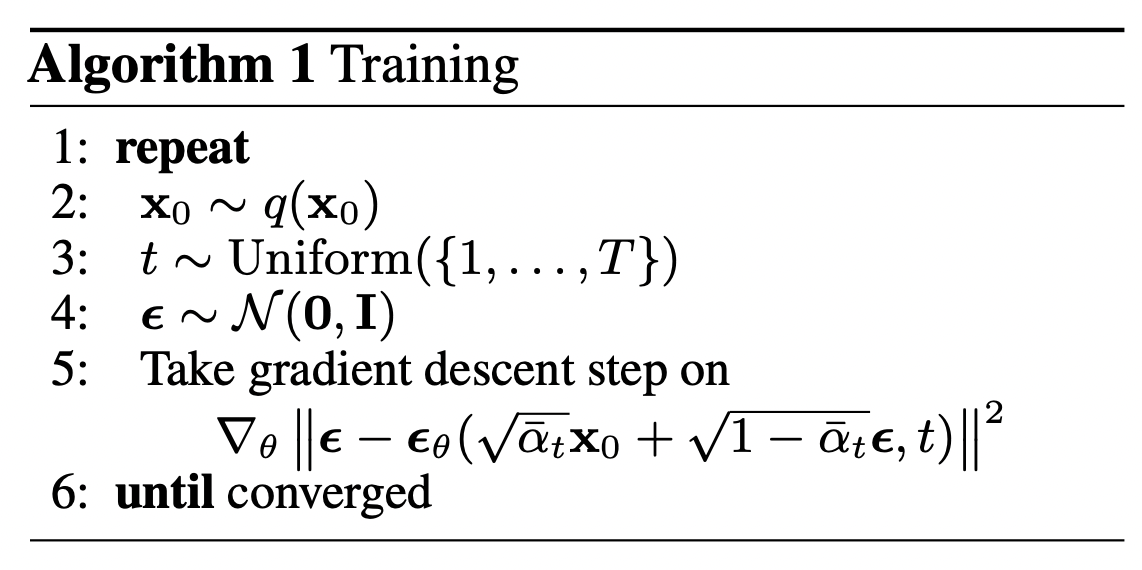

In [79]:
from torchvision.utils import save_image

overal_steps = 0
while overal_steps <= config.training.train_num_steps:
    data = next(dataloader)

    optimizer.zero_grad()

    batch,_ = data
    batch_size = batch.shape[0]
    batch = batch[0].to(device)

    # Algorithm 1 line 3: sample t uniformally for every example in the batch
    t = torch.randint(0, timesteps, (batch_size,), device=device).long()

    loss = p_losses(model, batch, t, loss_type="huber")

    if overal_steps % 100 == 0:
        print("Loss:", loss.item())

    loss.backward()
    optimizer.step()
    
    # save generated images
    if overal_steps != 0 and overal_steps % config.training.save_and_sample_every == 0:
        num_images_sample = 32
        all_images_list = sample(model, config.data.image_size, batch_size = num_images_sample, channels=args.channels)
        all_images_list = list(map(lambda n: sample(model, image_size = config.data.image_size, batch_size=n, channels=config.data.num_channels), batches))
        all_images = all_images_list[-1]
        all_images = (all_images + 1) * 0.5
        save_image(torch.from_numpy(all_images), str(config.training.results_folders / f'sample-{20000+overal_steps}.png'), nrow = 4)
        print("========== sample images and checkpoint are saved ========== \n")
        save_checkpoint(model, optimizer, scheduler, args, args.checkpoint_folder, 20000+overal_steps, args.save_to_wandb)

Loss: 0.026255831122398376


sampling loop time step: 100%|██████████| 1000/1000 [00:11<00:00, 84.93it/s]


TypeError: expected Tensor as element 0 in argument 0, but got list

# Sampling

(http://)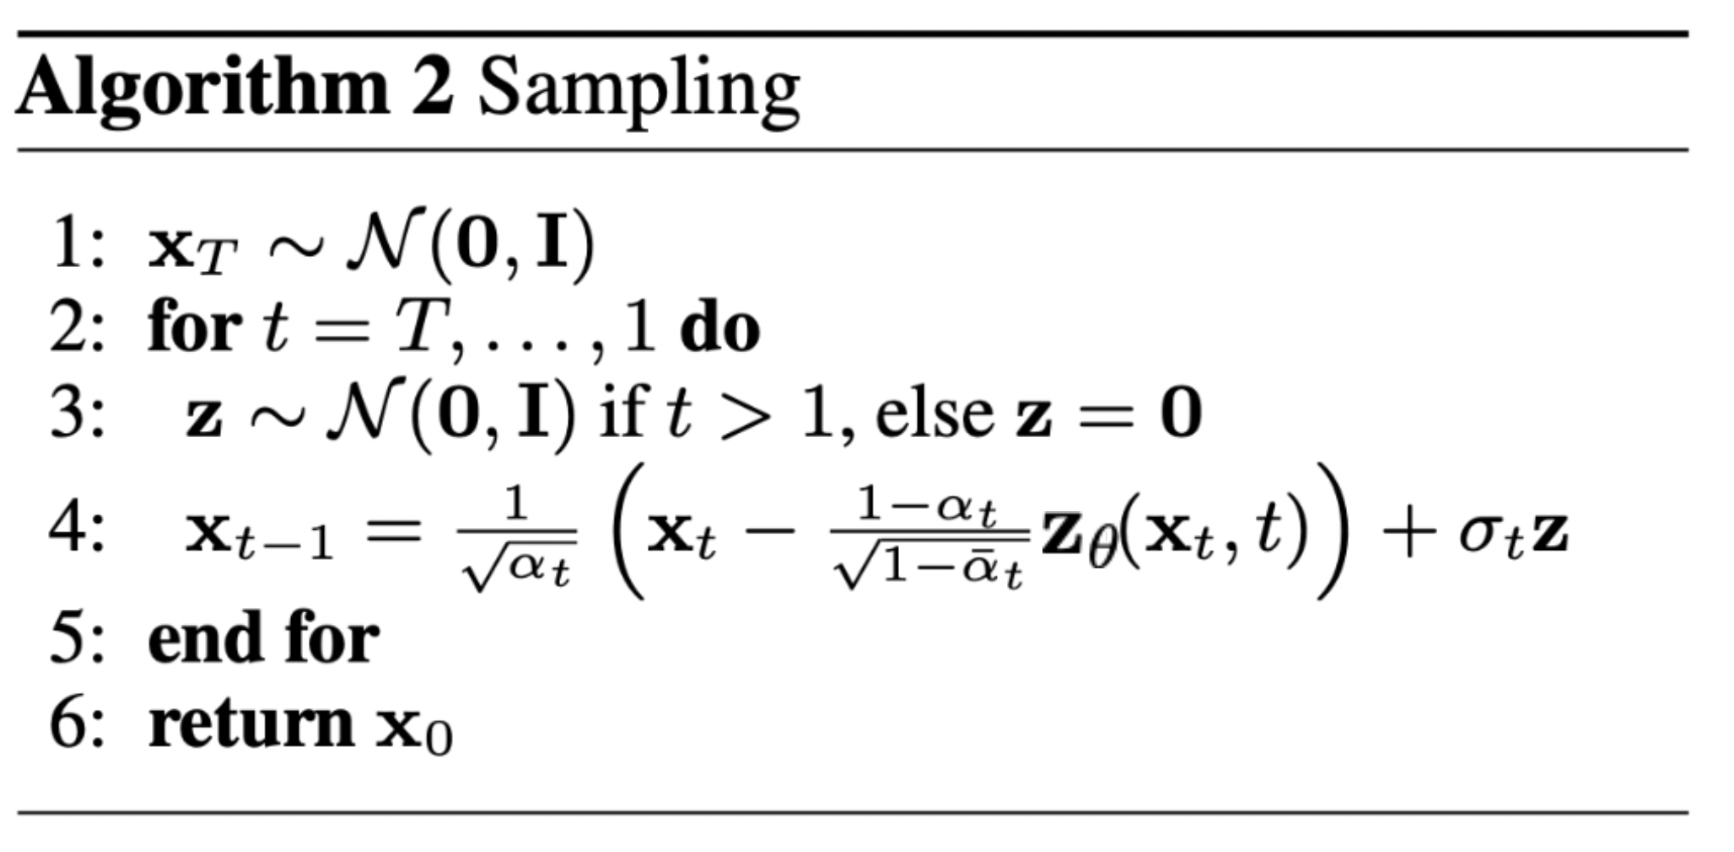

In [75]:
@torch.no_grad()
# sample p(x_{t-1}|x_t)
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)
    
    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model, shape):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    img = torch.randn(shape, device=device)
    imgs = []
    
    for i in tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img.cpu().numpy())
    return imgs

@torch.no_grad()
def sample(model, image_size, batch_size=16, channels=3):
    return p_sample_loop(model, shape=(batch_size, channels, image_size, image_size))

In [76]:
# sample 64 images
samples = sample(model, image_size=config.data.image_size, batch_size=64, channels=config.data.channels)

AttributeError: '\'channels\'\nDid you mean "num_channels" instead of "channels"?'

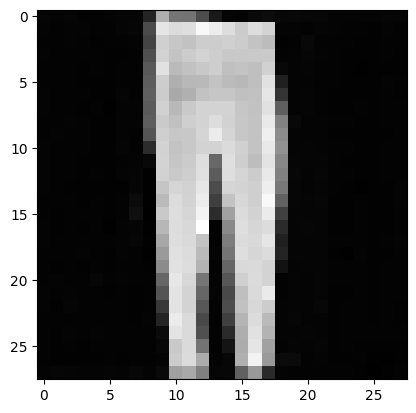

In [ ]:
# show a random one
random_index = 10
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

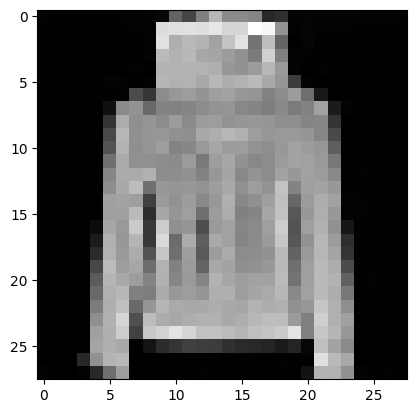

In [ ]:
# show a random one
random_index = 5
plt.imshow(samples[-1][random_index].reshape(image_size, image_size, channels), cmap="gray")

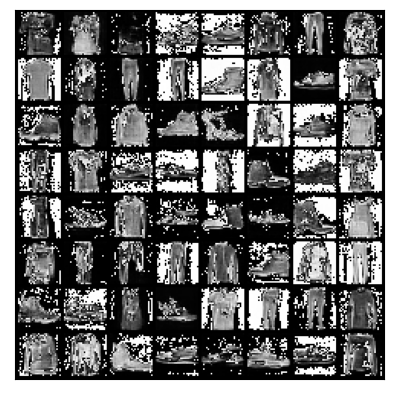

In [ ]:
from torchvision.utils import make_grid
from torchvision.transforms.functional import to_pil_image
img = make_grid(torch.from_numpy(samples[-1]))
def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = to_pil_image(img)
        axs[0, i].imshow(np.asarray(img), cmap='gray')
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
show(img)